#### Early Onset Colorectal Cancer

In [36]:
import os
import json
import time
from pathlib import Path
from typing import List, Dict, Any, Tuple
import requests
import pandas as pd
import numpy as np
import pickle
import tarfile, gzip, shutil
from numpy.linalg import norm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
GDC_API = "https://api.gdc.cancer.gov"
PROJECTS = ["TCGA-COAD", "TCGA-READ"] # colon + rectum adenocarcinoma
PAGE_SIZE = 200

SESSION = requests.Session()
SESSION.headers.update({"Content-Type": "application/json"})

##### Pull data & check outputs

In [4]:
## Handle pagination in GDC's API

def _paged_post(endpoint: str, payload: dict, page_size: int = PAGE_SIZE):
    """Yield all records from a paginated GDC API POST request."""
    url, offset = f"{GDC_API}/{endpoint}", 0
    while True:
        r = SESSION.post(url, params={"size": page_size, "from": offset},
                         data=json.dumps(payload), timeout=120)
        r.raise_for_status()
        hits = r.json().get("data", {}).get("hits", [])
        if not hits:
            break
        yield from hits
        offset += page_size
        if offset >= r.json().get("data", {}).get("pagination", {}).get("total", 0):
            break

In [5]:
## Query GDC for list of all open-access mutation files (MAF) for COAD+READ

def find_open_maf_files(projects=None):
    """
    Fetch open-access masked somatic mutation (MAF) files for TCGA projects (COAD/READ by default).
    Returns a DataFrame with file, case, and sample metadata.
    """
    projects = projects or PROJECTS

    # Build filters
    filters = {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": f, "value": v}}
            for f, v in [
                ("cases.project.project_id", projects),
                ("files.data_category", ["Simple Nucleotide Variation"]),
                ("files.data_type", ["Masked Somatic Mutation"]),
                ("files.experimental_strategy", ["WXS"]),
                ("files.access", ["open"])
            ]
        ],
    }

    fields = [
        "file_id", "file_name", "md5sum", "created_datetime", "updated_datetime",
        "analysis.workflow_type",
        "cases.case_id", "cases.submitter_id", "cases.project.project_id",
        "cases.samples.sample_id", "cases.samples.sample_type", "cases.samples.submitter_id"
    ]
    payload = {"filters": filters, "fields": ",".join(fields), "format": "JSON"}

    # Collect all hits
    rows = []
    for hit in _paged_post("files", payload):
        base = {
            "file_id": hit.get("file_id"),
            "file_name": hit.get("file_name"),
            "md5sum": hit.get("md5sum"),
            "created_datetime": hit.get("created_datetime"),
            "updated_datetime": hit.get("updated_datetime"),
            "workflow_type": hit.get("analysis", {}).get("workflow_type"),
        }
        for case in hit.get("cases", []):
            for s in case.get("samples", [{}]):  # ensure at least one row
                rows.append({
                    **base,
                    "case_id": case.get("case_id"),
                    "case_submitter_id": case.get("submitter_id"),
                    "project": case.get("project", {}).get("project_id"),
                    "sample_id": s.get("sample_id"),
                    "sample_submitter_id": s.get("submitter_id"),
                    "sample_type": s.get("sample_type"),
                })

    return pd.DataFrame(rows).drop_duplicates(["file_id", "sample_id", "case_id"]).reset_index(drop=True)

In [6]:
## Use '/data' bult endpoint to actually download MAFs by GDC file_id
## MAFs are very large, use manifest metadata first to select subset of MAFs to download

def download_files(file_ids, out_dir: str = "data/maf"):
    """
    Download one or more files from the GDC /data endpoint into out_dir.
    Handles batching, filenames, and safe writes. Returns list of file paths.
    """
    os.makedirs(out_dir, exist_ok=True)
    out_dir = Path(out_dir)
    paths = []

    for i in range(0, len(file_ids), 20):  # fetch in small batches
        chunk = file_ids[i:i+20]
        url = f"{GDC_API}/data/{','.join(chunk)}"
        r = SESSION.get(url, stream=True, timeout=600)
        r.raise_for_status()

        fname = r.headers.get("Content-Disposition", "").split("filename=")[-1].strip('"') \
                or (f"gdc_download_{i}.tar.gz" if len(chunk) > 1 else f"{chunk[0]}.maf.gz")

        fpath = out_dir / fname
        with open(fpath, "wb") as f:
            for b in r.iter_content(1 << 20):  # 1 MB chunks
                if b: f.write(b)

        paths.append(fpath)
        time.sleep(0.5)

    return paths

In [7]:
## Use the 'cases' endpoint to retrieve age at diagnosis (in days, convert to years)

def fetch_case_ages(projects=None):
    """
    Fetch mean age_at_diagnosis (years) per case for given TCGA projects.
    Returns: DataFrame [case_id, submitter_id, project, age_at_diagnosis_years].
    """
    projects = projects or PROJECTS

    filters = {
        "op": "and",
        "content": [
            {"op": "in", "content": {"field": "project.project_id", "value": projects}},
            {"op": "exists", "content": {"field": "diagnoses.age_at_diagnosis"}},
        ],
    }
    fields = [
        "case_id", "submitter_id", "project.project_id", "diagnoses.age_at_diagnosis"
    ]
    payload = {"filters": filters, "fields": ",".join(fields), "format": "JSON", "expand": "diagnoses"}

    rows = [
        {
            "case_id": h["case_id"],
            "submitter_id": h.get("submitter_id"),
            "project": h["project"]["project_id"],
            "age_at_diagnosis_years": (
                dx["age_at_diagnosis"] / 365.25 if isinstance(dx.get("age_at_diagnosis"), (int, float)) else None
            ),
        }
        for h in _paged_post("cases", payload)
        for dx in h.get("diagnoses", [])
    ]

    return (
        pd.DataFrame(rows)
        .groupby(["case_id", "submitter_id", "project"], as_index=False)
        .agg(age_at_diagnosis_years=("age_at_diagnosis_years", "mean"))
    )

In [8]:
## Categorize early/late stages

def label_early_late(age_years: float) -> str:
    """
    Categorize age into early / late / unknown onset groups.
    """
    if pd.isna(age_years):
        return "unknown"
    if age_years <= 40:
        return "early_onset"
    if age_years >= 70:
        return "late_onset"
    return "unknown"

def build_age_table():
    """
    Fetch patient ages and label each as early/late/unknown onset.
    Returns DataFrame with: case_id, submitter_id, project,
    age_at_diagnosis_years, group
    """
    cases = fetch_case_ages()
    cases["group"] = cases["age_at_diagnosis_years"].apply(label_early_late)
    return cases

In [9]:
## List mutation files that exist for TCGA colorectal cancer

maf_manifest = find_open_maf_files()
maf_manifest.head()

,file_id,file_name,md5sum,created_datetime,updated_datetime,workflow_type,case_id,case_submitter_id,project,sample_id,sample_submitter_id,sample_type
0,0a7104af-8c37-4492-9e72-f1e3f379e103,2c1ba550-574e-4bc3-a564-87e52ba76961.wxs.aliqu...,90bcd9b86636796cd4ee359b12d33e50,2022-08-01T12:47:55.680122-05:00,2024-07-31T04:41:28.097165-05:00,Aliquot Ensemble Somatic Variant Merging and M...,e394e9ec-7288-4ede-9ef8-41b631d100dd,TCGA-AA-3715,TCGA-COAD,90be4505-6489-43d9-b536-e90418dae2ed,TCGA-AA-3715-10A,Blood Derived Normal
1,0a7104af-8c37-4492-9e72-f1e3f379e103,2c1ba550-574e-4bc3-a564-87e52ba76961.wxs.aliqu...,90bcd9b86636796cd4ee359b12d33e50,2022-08-01T12:47:55.680122-05:00,2024-07-31T04:41:28.097165-05:00,Aliquot Ensemble Somatic Variant Merging and M...,e394e9ec-7288-4ede-9ef8-41b631d100dd,TCGA-AA-3715,TCGA-COAD,a172cf89-8820-4a84-97ef-6731e7ae71e2,TCGA-AA-3715-01A,Primary Tumor
2,48a5f19e-ae8b-4055-a5ff-961601aad512,f5ecb5b9-f00d-4d32-a3bd-42f8a168032c.wxs.aliqu...,11c466303107209c41e325cd90ba5de6,2022-08-01T12:52:19.222452-05:00,2024-07-31T04:44:00.711820-05:00,Aliquot Ensemble Somatic Variant Merging and M...,ac6a3df9-41b1-4e5a-a15e-f44481384c23,TCGA-AA-3860,TCGA-COAD,c1ea307f-cf39-4b09-8185-da56c37ce0d9,TCGA-AA-3860-01A,Primary Tumor
3,48a5f19e-ae8b-4055-a5ff-961601aad512,f5ecb5b9-f00d-4d32-a3bd-42f8a168032c.wxs.aliqu...,11c466303107209c41e325cd90ba5de6,2022-08-01T12:52:19.222452-05:00,2024-07-31T04:44:00.711820-05:00,Aliquot Ensemble Somatic Variant Merging and M...,ac6a3df9-41b1-4e5a-a15e-f44481384c23,TCGA-AA-3860,TCGA-COAD,d89599b3-35c7-4c31-8d3a-694da890c165,TCGA-AA-3860-10A,Blood Derived Normal
4,976e5a9e-dfe4-42e0-95fe-d7a33c8eecbc,d66378d1-4ec6-468f-8127-094989b2be3d.wxs.aliqu...,97124a969100de1709514298b965319b,2022-08-01T12:44:41.822225-05:00,2024-07-31T04:50:04.683869-05:00,Aliquot Ensemble Somatic Variant Merging and M...,f38d49b7-6cad-4460-abd0-3685a3b2d941,TCGA-AA-3814,TCGA-COAD,77abfd72-97d2-4abd-8633-99bedfffbe1d,TCGA-AA-3814-01A,Primary Tumor


In [10]:
## Pull & categorize ages at diagnosis for those cases

age_df = build_age_table()
#age_df["group"].value_counts(dropna=False)
age_df.head()

,case_id,submitter_id,project,age_at_diagnosis_years,group
0,0011a67b-1ba9-4a32-a6b8-7850759a38cf,TCGA-DC-6158,TCGA-READ,70.751540,late_onset
1,01240896-3f3f-4bf9-9799-55c87bfacf36,TCGA-F4-6854,TCGA-COAD,77.404517,late_onset
2,016c9c14-4c88-49f5-a11a-dd4bc282f11e,TCGA-DC-5337,TCGA-READ,68.999316,unknown
3,01ad5016-f691-4bca-82a0-910429d8d25b,TCGA-AA-3561,TCGA-COAD,72.334018,late_onset
4,01f493d4-229d-47a6-baa8-32a342c65d01,TCGA-AA-A00O,TCGA-COAD,83.000684,late_onset


In [11]:
## Select best MAF per case, merge with age info, and report QC

# Deduplicate
manifest_dedup = (
    maf_manifest
      .assign(
          is_primary = maf_manifest["sample_type"].eq("Primary Tumor"),
          wf_score = maf_manifest["workflow_type"].str.contains("MuTect2", case=False, na=False).astype(int),
          created_dt = pd.to_datetime(maf_manifest["created_datetime"], errors="coerce"),
          updated_dt = pd.to_datetime(maf_manifest["updated_datetime"], errors="coerce")
      )
      .sort_values(
          ["case_id", "is_primary", "wf_score", "updated_dt", "created_dt"],
          ascending=[True, False, False, False, False]
      )
      .drop_duplicates("case_id", keep="first")
      .drop(columns=["is_primary", "wf_score", "created_dt", "updated_dt"])
)

# Merge with clinical ages
manifest_with_age = (
    manifest_dedup
        .merge(age_df[["case_id","age_at_diagnosis_years","group"]],
               on="case_id", how="left")
        .query("group in ['early_onset','late_onset']")
        .reset_index(drop=True)
)

# Quality control summary
n_total = maf_manifest["case_id"].nunique()
n_dedup = manifest_dedup["case_id"].nunique()
n_merged = manifest_with_age["case_id"].nunique()
n_with_age = manifest_with_age["group"].notna().sum()

print(f"Total unique cases in raw manifest:     {n_total}")
print(f"Cases after deduplication (1 per case): {n_dedup}")
print(f"Cases retained after merging w/ age_df: {n_merged}")
print(f"Cases with known group (early/late):    {n_with_age}")
print("\nGroup breakdown:")
print(manifest_with_age["group"].value_counts(dropna=False))

Total unique cases in raw manifest:     583
Cases after deduplication (1 per case): 583
Cases retained after merging w/ age_df: 265
Cases with known group (early/late):    265

Group breakdown:
group
late_onset     250
early_onset     15
Name: count, dtype: int64


In [12]:
## Select balanced subset of cases and download their MAFs

n_per_group = 15

# Randomly sample up to n_per_group per onset group
subset_strat = (
    manifest_with_age
    .dropna(subset=["age_at_diagnosis_years"])
    .groupby("group", group_keys=False)
    .apply(lambda g: g.sample(n=min(n_per_group, len(g)), random_state=1))
    .reset_index(drop=True)
)

# Check
print("Sample counts:")
print(subset_strat["group"].value_counts())
print(subset_strat.groupby(["group", "project"]).size())

# Download selected MAFs
file_ids = subset_strat["file_id"].tolist()

# Create local data directory structure
os.makedirs("data/maf/downloads", exist_ok=True)

# Download selected MAFs to local directory
download_paths = download_files(file_ids, out_dir="data/maf/downloads")

/var/folders/vk/yxskvl4x63dbqzfj_xfn_wvw0000gn/T/ipykernel_56612/670174335.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  manifest_with_age


Sample counts:
group
early_onset    15
late_onset     15
Name: count, dtype: int64
group        project  
early_onset  TCGA-COAD    11
             TCGA-READ     4
late_onset   TCGA-COAD    10
             TCGA-READ     5
dtype: int64


##### Hypothesis testing
###### Hypothesis: early-onset colorectal tumours have more evidence of the colibactin mutational signature than late-onset tumours

In [14]:
# Create local directory structure for MAF processing
downloads = Path("data/maf/downloads")
RAW_DIR   = Path("data/maf/raw");      RAW_DIR.mkdir(parents=True, exist_ok=True)
UNZIP_DIR = Path("data/maf/unzipped"); UNZIP_DIR.mkdir(parents=True, exist_ok=True)

# Extract tarballs into RAW_DIR
for p in downloads.glob("*.tar.gz"):
    with tarfile.open(p, "r:gz") as tar:
        tar.extractall(RAW_DIR)

# Gunzip any compressed MAFs (*.maf.gz, *.txt.gz) into UNZIP_DIR
for gz in list(RAW_DIR.rglob("*.maf.gz")) + list(RAW_DIR.rglob("*.txt.gz")):
    out = UNZIP_DIR / gz.with_suffix('').name
    with gzip.open(gz, 'rb') as fin, open(out, 'wb') as fout:
        shutil.copyfileobj(fin, fout)

# Copy already-uncompressed .maf/.txt into UNZIP_DIR
for f in list(RAW_DIR.rglob("*.maf")) + list(RAW_DIR.rglob("*.txt")):
    shutil.copy2(f, UNZIP_DIR / f.name)

print("Unzipped MAFs:", len(list(UNZIP_DIR.glob('*'))))

Unzipped MAFs: 31


In [15]:
## Read MAFs, clean rows & attach group labels

unzipped = Path("data/maf/unzipped")
paths = list(unzipped.glob("*.maf")) + list(unzipped.glob("*.txt"))
mafs = pd.concat([pd.read_csv(p, sep="\t", comment="#", low_memory=False).assign(__src=p.name)
                  for p in paths], ignore_index=True)

# Keep SNPs
mafs = mafs[mafs["Variant_Type"] == "SNP"].copy()

# Attach early/late labels (TCGA 12-char barcode)
mafs["patient_barcode"] = mafs["Tumor_Sample_Barcode"].astype(str).str[:12]
mafs = mafs.merge(
    age_df[["submitter_id","group","age_at_diagnosis_years"]]
      .drop_duplicates()
      .rename(columns={"submitter_id":"patient_barcode"}),
    on="patient_barcode", how="left"
)

# Minimal cleaning for context fetch + labeling
mafs["Chromosome"] = (mafs["Chromosome"].astype(str)
                      .str.replace("^chr","",regex=True)
                      .str.replace("^MT$","M",regex=True))
mafs = mafs[mafs["Chromosome"].isin([str(i) for i in range(1,23)]+["X","Y","M"])]
mafs["Start_Position"] = pd.to_numeric(mafs["Start_Position"], errors="coerce").astype("Int64")
mafs["End_Position"] = pd.to_numeric(mafs.get("End_Position", mafs["Start_Position"]), errors="coerce") \
                           .fillna(mafs["Start_Position"]).astype("Int64")
for c in ("Reference_Allele","Tumor_Seq_Allele2"):
    mafs[c] = mafs[c].astype(str).str.upper()

# Drop rows missing essentials; cast ints
mafs = mafs.dropna(subset=["Chromosome","Start_Position","Reference_Allele","Tumor_Seq_Allele2","Tumor_Sample_Barcode"]).copy()
mafs["Start_Position"] = mafs["Start_Position"].astype(int)
mafs["End_Position"]   = mafs["End_Position"].astype(int)

# Quick sanity check
print("Rows:", len(mafs), "| unique samples:", mafs["Tumor_Sample_Barcode"].nunique())
print(mafs["group"].value_counts(dropna=False))
mafs.head(3)

Rows: 27269 | unique samples: 30
group
early_onset    22154
late_onset      5115
Name: count, dtype: int64


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,callers,__src,id,filename,md5,size,state,patient_barcode,group,age_at_diagnosis_years
0,RNF19B,127544.0,BCM,GRCh38,1,32942318,32942318,+,Missense_Mutation,SNP,...,muse;mutect2;varscan2,e28d791d-5838-4615-9b00-81d08199b71e.wxs.aliqu...,NaN,NaN,NaN,NaN,NaN,TCGA-AA-3955,early_onset,38.839151
1,CSMD2,114784.0,BCM,GRCh38,1,33935791,33935791,+,Silent,SNP,...,muse;mutect2;varscan2,e28d791d-5838-4615-9b00-81d08199b71e.wxs.aliqu...,NaN,NaN,NaN,NaN,NaN,TCGA-AA-3955,early_onset,38.839151
2,ELAVL4,1996.0,BCM,GRCh38,1,50195744,50195744,+,Missense_Mutation,SNP,...,muse;mutect2;varscan2,e28d791d-5838-4615-9b00-81d08199b71e.wxs.aliqu...,NaN,NaN,NaN,NaN,NaN,TCGA-AA-3955,early_onset,38.839151


In [16]:
## Fetch trinucleotide context from UCSC API (with progress bar)

CACHE = Path("data/maf/ctx_map.pkl")

def fetch_seq(ch: str, pos: int, tries=3):
    if pos <= 1:
        return None
    url = f"http://api.genome.ucsc.edu/getData/sequence?genome=hg38;chrom=chr{ch};start={pos-2};end={pos+1}"
    for i in range(tries):
        try:
            r = requests.get(url, timeout=15)
            if r.ok:
                return r.json()["dna"].upper()
        except Exception:
            pass
        time.sleep(0.5*(i+1))
    return None

# Unique keys to query
keys = set(map(tuple,
               mafs[["Chromosome","Start_Position"]]
               .drop_duplicates()
               .astype({"Start_Position": int})
               .values))

# Load cache (if any)
ctx_map = pickle.load(open(CACHE, "rb")) if CACHE.exists() else {}

# Fetch only what’s missing (with progress bar)
# MAX_TEST = 1000 # subset for infra build
to_fetch = [k for k in keys if k not in ctx_map]#[:MAX_TEST]
for ch, pos in tqdm(to_fetch, total=len(to_fetch), desc="Fetching contexts"):
    ctx_map[(str(ch), int(pos))] = fetch_seq(str(ch), int(pos))

# Save cache and report
with open(CACHE, "wb") as f:
    pickle.dump(ctx_map, f)

print(f"Contexts available: {sum(v is not None for v in ctx_map.values())}/{len(keys)} "
      f"(fetched {len(to_fetch)})")

Fetching contexts: 100%|██████████| 27077/27077 [59:46:41<00:00,  7.95s/it]      

Contexts available: 23132/27077 (fetched 27077)


In [17]:
## Build SBS-96 matrix

# Reverse complement utilities
comp = str.maketrans("ACGT", "TGCA")
def revcomp(s: str) -> str: return s.translate(comp)[::-1]

# COSMIC-style 96 labels from POV of pyrimidine (C or T) base
subs  = ["C>A","C>G","C>T","T>A","T>C","T>G"]
bases = list("ACGT")
labels96 = [a+"["+s+"]"+b for s in subs for a in bases for b in bases]
samples  = mafs["Tumor_Sample_Barcode"].unique().tolist()

# Make one SBS label for a row
def make_label(r):
    tri = ctx_map.get((str(r.Chromosome), int(r.Start_Position)))
    if not tri or len(tri) != 3:
        return None
    ref, alt, tri = str(r.Reference_Allele).upper(), str(r.Tumor_Seq_Allele2).upper(), tri.upper()
    if ref in "AG":  # normalize to pyrimidine convention
        ref, alt, tri = revcomp(ref), revcomp(alt), revcomp(tri)
    sub = f"{ref}>{alt}"
    lbl = f"{tri[0]}[{sub}]{tri[2]}"
    return lbl if (sub in subs and lbl in labels96) else None

# Create labels, aggregate counts for full 96×N matrix, then normalize per sample
mafs["sbs_label"] = mafs.apply(make_label, axis=1)
counts = (mafs.dropna(subset=["sbs_label"])
              .groupby(["sbs_label","Tumor_Sample_Barcode"])
              .size()
              .unstack(fill_value=0))
sbs96 = counts.reindex(index=labels96, columns=samples, fill_value=0).astype(int)
sbs96_norm = sbs96.div(sbs96.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)

print("SBS96 shape:", sbs96.shape,
      "| nonzero entries:", int((sbs96.values>0).sum()),
      "| skipped rows:", int(mafs["sbs_label"].isna().sum()))

SBS96 shape: (96, 30) | nonzero entries: 1368 | skipped rows: 3976


In [18]:
with zipfile.ZipFile("COSMIC_catalogue-signatures_SBS96_v3.4.zip", "r") as z:
    z.extractall("cosmic_sbs_v3.4")


Cosine similarity to SBS88 by group:
             count      mean       std       min       25%       50%  \
group                                                                  
early_onset   15.0  0.119511  0.030796  0.087071  0.099312  0.112597   
late_onset    15.0  0.116766  0.047222  0.044277  0.089557  0.111369   

                  75%       max  
group                            
early_onset  0.123727  0.180893  
late_onset   0.128816  0.230999  


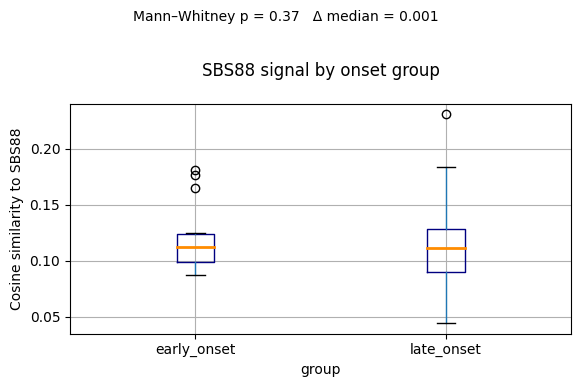

In [19]:
# Compare to SBS88 using COSMIC v3.4 format

# Load and extract SBS88 vector
cosmic = pd.read_csv("cosmic_sbs_v3.4/COSMIC_v3.4_SBS_GRCh38.txt", sep="\t")
sbs88 = cosmic.set_index("Type")["SBS88"].astype(float)   # Each Type = trinucleotide context
sbs88_vec = sbs88.reindex(sbs96_norm.index).fillna(0).values

# Compute cosine similarity per sample
def cosine(col):
    a, b = col.values, sbs88_vec
    da, db = norm(a), norm(b)
    return float(a @ b / (da * db)) if da and db else np.nan

cos_df = (sbs96_norm.apply(cosine, axis=0)
          .rename("cos_sim_SBS88")
          .reset_index()
          .rename(columns={"index": "Tumor_Sample_Barcode"}))

# Attach early/late group labels
grp = (mafs[["Tumor_Sample_Barcode", "group"]]
       .drop_duplicates()
       .set_index("Tumor_Sample_Barcode")["group"])
cos_df["group"] = cos_df["Tumor_Sample_Barcode"].map(grp)

# Summarize
print("\nCosine similarity to SBS88 by group:")
print(cos_df.groupby("group")["cos_sim_SBS88"].describe())

# Mann–Whitney u-test
early = cos_df.query("group == 'early_onset'")["cos_sim_SBS88"].dropna()
late  = cos_df.query("group == 'late_onset'")["cos_sim_SBS88"].dropna()
if len(early) and len(late):
    u, p = mannwhitneyu(early, late, alternative="greater")
    median_diff = np.median(early) - np.median(late)
else:
    u, p, median_diff = np.nan, np.nan, np.nan

# Boxplot results
fig, ax = plt.subplots(figsize=(6, 4))
cos_df.boxplot(column="cos_sim_SBS88", by="group", ax=ax,
               boxprops=dict(color="navy"),
               medianprops=dict(color="darkorange", linewidth=2))

plt.suptitle("")
ax.set_title("SBS88 signal by onset group", pad=20)
ax.set_ylabel("Cosine similarity to SBS88")

# Add annotation in figure-relative coordinates
fig.text(0.5, 0.92, f"Mann–Whitney p = {p:.3g}   Δ median = {median_diff:.3f}",
         ha="center", va="bottom", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

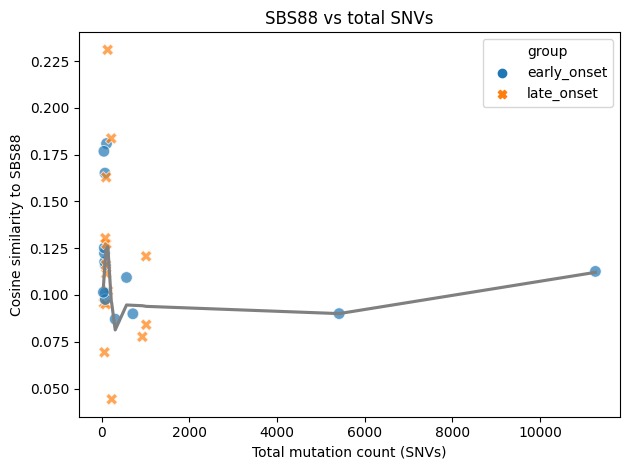

In [27]:
# Scatter plot of total SNVs vs cosine similarity to SBS88

# total SNVs per sample
total_counts = sbs96.sum(axis=0).rename('Mutations')

# SBS88 reference vector
cosmic = pd.read_csv("cosmic_sbs_v3.4/COSMIC_v3.4_SBS_GRCh38.txt", sep="\t")
sig_vec = (
    cosmic.set_index("Type")["SBS88"]
          .astype(float)
          .reindex(sbs96_norm.index)
          .fillna(0)
          .values
)

def cosine(col, ref=sig_vec):
    a = col.values
    da, db = norm(a), norm(ref)
    return (a @ ref) / (da * db) if da and db else np.nan

# cosine similarity per sample
cos_df = sbs96_norm.apply(cosine, axis=0).rename("cos_sim_SBS88").to_frame()
cos_df["Mutations"] = total_counts
cos_df["group"] = (
    mafs.drop_duplicates("Tumor_Sample_Barcode")
        .set_index("Tumor_Sample_Barcode")["group"]
)

# scatter with LOWESS trend
sns.scatterplot(
    data=cos_df.reset_index(),
    x="Mutations",
    y="cos_sim_SBS88",
    hue="group",
    style="group",
    s=70,
    alpha=0.7
)
sns.regplot(
    data=cos_df.reset_index(),
    x="Mutations",
    y="cos_sim_SBS88",
    scatter=False,
    color="grey",
    lowess=True
)
plt.title("SBS88 vs total SNVs")
plt.ylabel("Cosine similarity to SBS88")
plt.xlabel("Total mutation count (SNVs)")
plt.tight_layout()
plt.show()

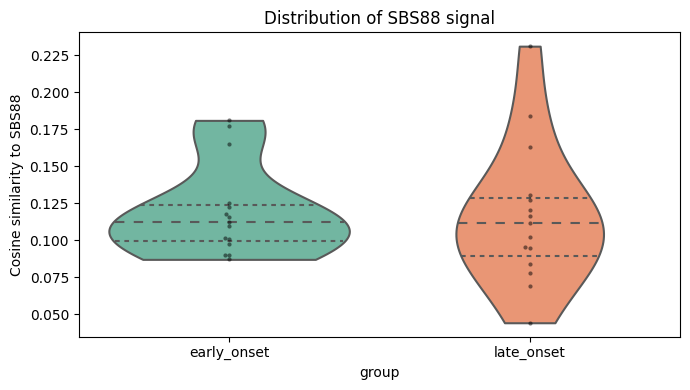

In [37]:
# Tail-oriented density view

plt.figure(figsize=(7,4))
sns.violinplot(
    data=cos_df.reset_index(),
    x="group",
    y="cos_sim_SBS88",
    cut=0,
    inner="quartile",
    palette="Set2"
)
sns.swarmplot(
    data=cos_df.reset_index(),
    x="group",
    y="cos_sim_SBS88",
    color="k",
    size=3,
    alpha=0.5
)
plt.ylabel("Cosine similarity to SBS88")
plt.title("Distribution of SBS88 signal")
plt.tight_layout()
plt.show()

##### Compare other signatures

In [24]:
def compare_signature(signature_name, sbs96_norm, mafs, cosmic_path, show_plot=True):
    """
    Compare early vs late onset samples for a given COSMIC SBS signature.

    Args:
        signature_name (str): e.g. "SBS88", "SBS18"
        sbs96_norm (pd.DataFrame): normalized SBS-96 matrix (96 x samples)
        mafs (pd.DataFrame): contains 'Tumor_Sample_Barcode' and 'group' columns
        cosmic_path (str): path to COSMIC signatures file (v3.4 GRCh38)
        show_plot (bool): whether to display the boxplot

    Returns:
        dict: {'signature': str, 'p_value': float, 'median_diff': float, 'u_stat': float}
    """
    # Load COSMIC signatures and extract desired column
    cosmic = pd.read_csv(cosmic_path, sep="\t")
    if signature_name not in cosmic.columns:
        raise ValueError(f"Signature {signature_name} not found in file.")
    sig_vec = cosmic.set_index("Type")[signature_name].astype(float)
    sig_vec = sig_vec.reindex(sbs96_norm.index).fillna(0).values

    # Cosine similarity per sample
    def cosine(col):
        a, b = col.values, sig_vec
        da, db = norm(a), norm(b)
        return float(a @ b / (da * db)) if da and db else np.nan

    cos_df = (sbs96_norm.apply(cosine, axis=0)
              .rename(f"cos_sim_{signature_name}")
              .reset_index()
              .rename(columns={"index": "Tumor_Sample_Barcode"}))

    # Attach onset group
    grp = (mafs[["Tumor_Sample_Barcode","group"]]
           .drop_duplicates()
           .set_index("Tumor_Sample_Barcode")["group"])
    cos_df["group"] = cos_df["Tumor_Sample_Barcode"].map(grp)

    # Compute test
    early = cos_df.query("group == 'early_onset'")[f"cos_sim_{signature_name}"].dropna()
    late  = cos_df.query("group == 'late_onset'")[f"cos_sim_{signature_name}"].dropna()
    if len(early) and len(late):
        u, p = mannwhitneyu(early, late, alternative="greater")
        median_diff = np.median(early) - np.median(late)
    else:
        u, p, median_diff = np.nan, np.nan, np.nan

    # Optional visualization
    if show_plot:
        fig, ax = plt.subplots(figsize=(6,4))
        cos_df.boxplot(column=f"cos_sim_{signature_name}", by="group", ax=ax,
                       boxprops=dict(color="navy"),
                       medianprops=dict(color="darkorange", linewidth=2))
        plt.suptitle("")
        ax.set_title(f"{signature_name} signal by onset group", pad=20)
        ax.set_ylabel(f"Cosine similarity to {signature_name}")
        fig.text(0.5, 0.92,
                 f"Mann–Whitney p = {p:.3g}   Δ median = {median_diff:.3f}",
                 ha="center", va="bottom", fontsize=10)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()

    return {
        "signature": signature_name,
        "u_stat": u,
        "p_value": p,
        "median_diff": median_diff
    }

In [25]:
cosmic_path = "cosmic_sbs_v3.4/COSMIC_v3.4_SBS_GRCh38.txt"
signatures_to_test = ["SBS18", "SBS28", "SBS88", "SBS6", "SBS15", "SBS20", "SBS26", "SBS44"]

results = [compare_signature(sig, sbs96_norm, mafs, cosmic_path, show_plot=False)
            for sig in signatures_to_test]

results_df = pd.DataFrame(results).sort_values("p_value")
print(results_df)

  signature  u_stat   p_value  median_diff
0     SBS18   130.0  0.240366     0.047261
1     SBS28   128.0  0.266915     0.018841
2     SBS88   121.0  0.370011     0.001228
5     SBS20   113.0  0.500000     0.000723
7     SBS44    96.0  0.759634     0.005141
3      SBS6    93.0  0.796607    -0.055655
4     SBS15    89.0  0.840247    -0.134748
6     SBS26    89.0  0.840247    -0.039254


In [30]:
# Cosine similarity to multiple signatures

def cosine_similarity_to(sig_name, sbs96_norm, cosmic_path):
    """Return a Series of cosine similarity values (indexed by sample)."""
    cosmic = pd.read_csv(cosmic_path, sep="\t")
    if sig_name not in cosmic.columns:
        raise ValueError(f"{sig_name} not present in COSMIC file.")
    vec = cosmic.set_index("Type")[sig_name].astype(float)
    vec = vec.reindex(sbs96_norm.index).fillna(0).values
    
    def cos(col):
        a = col.values
        b = vec
        da, db = norm(a), norm(b)
        return float(a @ b / (da * db)) if da and db else np.nan
    
    return (sbs96_norm.apply(cos, axis=0)
                     .rename(f"cos_sim_{sig_name}")
                     .rename_axis("Tumor_Sample_Barcode"))

cosmic_path = "cosmic_sbs_v3.4/COSMIC_v3.4_SBS_GRCh38.txt"
signatures = ["SBS88", "SBS18", "SBS28"]   # add others if needed

cos_table = pd.concat(
    [cosine_similarity_to(sig, sbs96_norm, cosmic_path) for sig in signatures],
    axis=1
)

# Attach onset group
group_map = (mafs[["Tumor_Sample_Barcode","group"]]
             .drop_duplicates()
             .set_index("Tumor_Sample_Barcode")["group"])
cos_table["group"] = cos_table.index.map(group_map)
cos_table.dropna(subset=[f"cos_sim_{s}" for s in signatures], inplace=True)

cos_table.head()

,cos_sim_SBS88,cos_sim_SBS18,cos_sim_SBS28,group
Tumor_Sample_Barcode,,,,
TCGA-AA-3955-01A-02W-0995-10,0.180893,0.344683,0.208828,early_onset
TCGA-AG-A002-01A-01W-A00K-09,0.112597,0.549633,0.113032,early_onset
TCGA-CM-6675-01A-11D-1835-10,0.165109,0.308378,0.030352,early_onset
TCGA-F5-6702-01A-11D-1826-10,0.095690,0.305005,0.037578,late_onset
TCGA-AZ-6599-01A-11D-1771-10,0.044277,0.183722,0.020706,late_onset


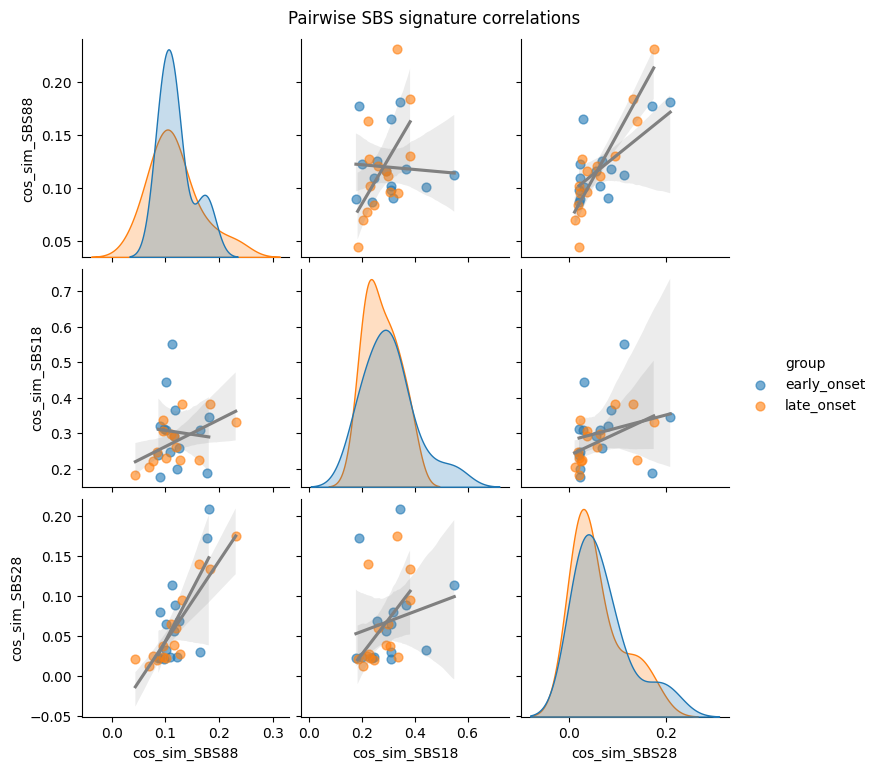

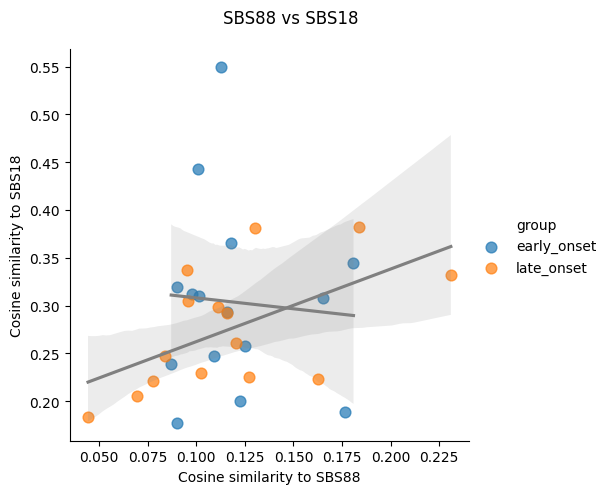

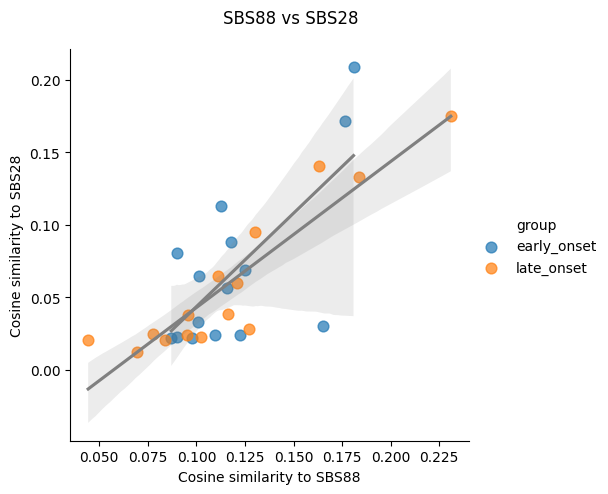

In [40]:
# Pairwise correlations

sig_cols = [f"cos_sim_{s}" for s in signatures]

g = sns.pairplot(
    cos_table,
    vars=sig_cols,
    hue="group",
    kind="reg",
    diag_kind="kde",
    plot_kws=dict(scatter_kws=dict(alpha=.6, s=40),
                  line_kws=dict(color="grey"))
)
g.figure.suptitle("Pairwise SBS signature correlations", y=1.02)

for partner in ["SBS18", "SBS28"]:
    grid = sns.lmplot(
        data=cos_table,
        x="cos_sim_SBS88",
        y=f"cos_sim_{partner}",
        hue="group",
        height=5,
        scatter_kws=dict(alpha=0.7, s=60),
        line_kws=dict(color="grey")
    )
    grid.set(
        xlabel="Cosine similarity to SBS88",
        ylabel=f"Cosine similarity to {partner}"
    )
    grid.figure.subplots_adjust(top=0.9)
    grid.figure.suptitle(f"SBS88 vs {partner}")